<a href="https://colab.research.google.com/github/PatriciaMoraru/AA_Laboratory_Works/blob/main/Laboratory_Work_2/Laboratory_w2(Google_Colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sorting Algorithms (Laboratory Work Nr.2)

In [1]:
import math
import timeit
import tracemalloc
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean, stdev
import pandas as pd
import sys
import numpy as np

## Input Data

In [2]:
input_sizes = [10**2, 10**3, 10**4, 10**5, 10**6]

def generate_inputs(n):
    np.random.seed(42)

    return {
        "Random": np.random.randint(0, 100000, size=n).tolist(),
        "Sorted": list(range(n)),
        "Reverse-Sorted": list(range(n, 0, -1)),
        "Few-Unique": np.random.choice([10, 20, 30, 40, 50], size=n).tolist(),
        "Nearly-Sorted": sorted(np.random.randint(0, 100000, size=n))[:n//2] + sorted(np.random.randint(0, 100000, size=n))[n//2:]
    }

input_data = {size: generate_inputs(size) for size in input_sizes}

## Performance Measurement Functions
These functions will track execution time and memory usage.

In [3]:
# Measure execution time
def measure_time(func, n, repetitions=5):
    times = timeit.repeat(lambda: func(n), repeat=repetitions, number=1)
    avg_time = sum(times) / repetitions
    std_time = (sum((t - avg_time) ** 2 for t in times) / repetitions) ** 0.5
    return avg_time, std_time

In [4]:
# Measure memory usage
def measure_memory(func, n):
    tracemalloc.start()
    func(n)
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return peak

## Experiment Function

In [5]:
def run_experiment(func, input_sizes, repetitions=5):
    results = {size: {'time': None, 'std_time': None, 'memory': None} for size in input_sizes}

    print(f'{"Input Size":>10} | {"Time (s)":>12} | {"Memory (bytes)":>15}')
    print('-' * 42)

    for n in tqdm(input_sizes, desc="Running experiments"):
        try:
            avg_time, std_time = measure_time(func, n, repetitions=repetitions)
            memory_used = measure_memory(func, n)

            results[n]['time'] = avg_time
            results[n]['std_time'] = std_time
            results[n]['memory'] = memory_used

            print(f'{n:10d} | {avg_time:12.6f} ± {std_time:.6f} | {memory_used:15,}')
        except Exception as e:
            print(f"Error at input size {n}: {e}")
    return results

## Visualization Function

In [6]:
def create_results_table(algorithm_results, input_sizes):
    columns = ["Algorithm"] + input_sizes
    table_data = []

    for algo_name, results in algorithm_results.items():
        row = [algo_name] + [results[n]['time'] for n in input_sizes]
        table_data.append(row)

    df_results = pd.DataFrame(table_data, columns=columns)
    print("\nSorting Algorithm Performance Table:")
    print(df_results)
    return df_results

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_per_dataset_type(all_results_standard, all_results_optimized, dataset_types, sorting_algorithms):
    cols = 2
    rows = len(dataset_types)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows), squeeze=False)

    for i, dataset in enumerate(dataset_types):
        dataset_key = dataset


        if dataset_key not in all_results_standard or dataset_key not in all_results_optimized:
            print(f"Warning: No data found for dataset '{dataset_key}'")
            continue

        # Left graph: Standard sorting
        ax1 = axes[i, 0]
        ax1.set_title(f"Standard Sorting on {dataset} Dataset")

        if dataset_key in all_results_standard:
            for algo_name in sorting_algorithms:
                if algo_name in all_results_standard[dataset_key]:
                    results = all_results_standard[dataset_key][algo_name]

                    if not results:
                        print(f"Skipping {algo_name} for {dataset} (no results)")
                        continue

                    sizes = sorted(results.keys())
                    times = np.array([results[n].get('time', np.nan) if results[n].get('time') is not None else np.nan for n in sizes], dtype=np.float64)

                    print(f"Plotting Standard: {dataset} - {algo_name}")
                    print(f"Sizes: {sizes}")
                    print(f"Times: {times}")

                    if not sizes or np.all(np.isnan(times)):
                        print(f"Skipping {dataset} - {algo_name} (No valid data)")
                        continue

                    ax1.plot(sizes, times, marker='o', label=algo_name)

        ax1.set_xscale("log")
        ax1.set_yscale("log")
        ax1.set_xlabel("Input Size (n)")
        ax1.set_ylabel("Execution Time (s)")
        ax1.legend()
        ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

        # Right graph: Optimized sorting
        ax2 = axes[i, 1]
        ax2.set_title(f"Optimized Sorting on {dataset} Dataset")

        if dataset_key in all_results_optimized:
            for algo_name in sorting_algorithms:
                optimized_algo_name = f"Optimized {algo_name}"
                if optimized_algo_name in all_results_optimized[dataset_key]:
                    results = all_results_optimized[dataset_key][optimized_algo_name]

                    if not results:
                        print(f"Skipping {optimized_algo_name} for {dataset} (no results)")
                        continue

                    sizes = sorted(results.keys())
                    times = np.array([results[n].get('time', np.nan) if results[n].get('time') is not None else np.nan for n in sizes], dtype=np.float64)

                    print(f"Plotting Optimized: {dataset} - {optimized_algo_name}")
                    print(f"Sizes: {sizes}")
                    print(f"Times: {times}")

                    if not sizes or np.all(np.isnan(times)):
                        print(f"Skipping {dataset} - {optimized_algo_name} (No valid data)")
                        continue

                    ax2.plot(sizes, times, marker='s', linestyle="--", label=optimized_algo_name)

        ax2.set_xscale("log")
        ax2.set_yscale("log")
        ax2.set_xlabel("Input Size (n)")
        ax2.set_ylabel("Execution Time (s)")
        ax2.legend()
        ax2.grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()

In [8]:
def analyze_algorithm(func, algorithm_name, input_sizes, repetitions=5):
    print(f'\nAnalyzing {algorithm_name}...')
    results = run_experiment(func, input_sizes, repetitions)
    return results

## Quick Sort

Lomuto partition scheme - Original

In [9]:
def quick_sort(arr):
    if len(arr) <= 1:
        return arr

    pivot = arr[-1]
    smaller, equal, larger = [], [], []

    for num in arr:
        if num < pivot:
            smaller.append(num)
        elif num == pivot:
            equal.append(num)
        else:
            larger.append(num)

    return quick_sort(smaller) + equal + quick_sort(larger)

In [10]:
def partition(arr, low, high):
    pivot = arr[high]
    i = low

    for j in range(low, high):
        if arr[j] < pivot:
            arr[i], arr[j] = arr[j], arr[i]
            i += 1

    arr[i], arr[high] = arr[high], arr[i]
    return i

Optimized Version (Median of Three - Pivot Selection)

In [11]:
def optimized_quick_sort(arr):
    if len(arr) <= 1:
        return arr

    first = arr[0]
    middle = arr[len(arr) // 2]
    last = arr[-1]
    pivot = sorted([first, middle, last])[1]

    left = [x for x in arr if x < pivot]
    middle = [x for x in arr if x == pivot]
    right = [x for x in arr if x > pivot]

    return optimized_quick_sort(left) + middle + optimized_quick_sort(right)


## Merge Sort

In [12]:
def merge_sort(arr):
    if len(arr) > 1:
        left_arr = arr[:len(arr)//2]
        right_arr = arr[len(arr)//2:]

        merge_sort(left_arr)
        merge_sort(right_arr)

        i = 0
        j = 0
        k = 0

        while i < len(left_arr) and j < len(right_arr):
            if left_arr[i] < right_arr[j]:
                arr[k] = left_arr[i]
                i += 1
            else:
                arr[k] = right_arr[j]
                j += 1
            k += 1

        while i < len(left_arr):
            arr[k] = left_arr[i]
            i += 1
            k += 1

        while j < len(right_arr):
            arr[k] = right_arr[j]
            j += 1
            k += 1

### Bootom-Up Merge Sort (Optimized)

Bottom-Up Merge Sort is an iterative (non-recursive) version of Merge Sort that avoids recursive function calls by directly merging subarrays of increasing size.

- Start with small subarrays of size 1 (individual elements).
- Merge adjacent subarrays into sorted arrays of size 2, 4, 8, 16, ..., until the entire array is merged.
- Repeat merging in increasing powers of two (size *= 2) until the entire list is sorted.

In [13]:
def merge(arr, left, mid, right):
    left_part = arr[left:mid + 1]
    right_part = arr[mid + 1:right + 1]

    i = j = 0
    k = left

    while i < len(left_part) and j < len(right_part):
        if left_part[i] < right_part[j]:
            arr[k] = left_part[i]
            i += 1
        else:
            arr[k] = right_part[j]
            j += 1
        k += 1

    while i < len(left_part):
        arr[k] = left_part[i]
        i += 1
        k += 1

    while j < len(right_part):
        arr[k] = right_part[j]
        j += 1
        k += 1


In [14]:
def bottom_up_merge_sort(arr):
    n = len(arr)
    size = 1
    while size < n:
        for left in range(0, n, 2 * size):
            mid = min(left + size - 1, n - 1)
            right = min(left + 2 * size - 1, n - 1)
            if mid < right:
                merge(arr, left, mid, right)
        size *= 2

## Heap Sort

In [15]:
def heapify(mylist, n, i):
    max_idx = i
    left = 2 * i + 1
    right = 2 * i + 2

    if left < n and mylist[left] > mylist[max_idx]:
        max_idx = left
    if right < n and mylist[right] > mylist[max_idx]:
        max_idx = right
    if max_idx != i:
        mylist[i], mylist[max_idx] = mylist[max_idx], mylist[i]
        heapify(mylist, n, max_idx)

In [16]:
def heap_sort(mylist):
    n = len(mylist)

    for i in range(n // 2 - 1, -1, -1):
        heapify(mylist, n, i)

    for i in range(n - 1, 0, -1):
        mylist[i], mylist[0] = mylist[0], mylist[i]
        heapify(mylist, i, 0)

Ternary Heap Sort (Optimized)

In [17]:
def heapify_ternary(arr, n, i):
    while True:
        largest = i
        left = 3 * i + 1
        mid = 3 * i + 2
        right = 3 * i + 3

        if left < n and arr[left] > arr[largest]:
            largest = left
        if mid < n and arr[mid] > arr[largest]:
            largest = mid
        if right < n and arr[right] > arr[largest]:
            largest = right

        if largest == i:
            break

        arr[i], arr[largest] = arr[largest], arr[i]
        i = largest

In [18]:
def heap_sort_ternary(arr):
    n = len(arr)

    # Build the ternary heap (bottom-up approach)
    for i in range(n // 3 - 1, -1, -1):
        heapify_ternary(arr, n, i)

    # Heap sort
    for i in range(n - 1, 0, -1):
        arr[i], arr[0] = arr[0], arr[i]
        heapify_ternary(arr, i, 0)

## Radix Sort

In [19]:
def counting_sort(arr, exp):
    n = len(arr)
    output = [0] * n
    count = [0] * 10

    for i in range(n):
        index = (arr[i] // exp) % 10
        count[index] += 1

    for i in range(1, 10):
        count[i] += count[i - 1]

    for i in range(n - 1, -1, -1):
        index = (arr[i] // exp) % 10
        output[count[index] - 1] = arr[i]
        count[index] -= 1

    for i in range(n):
        arr[i] = output[i]

def radix_sort(arr):
    if not arr:
        return arr

    max_num = max(arr)

    exp = 1
    while max_num // exp > 0:
        counting_sort(arr, exp)
        exp *= 10

    return arr

Iterative MSD Radix Sort (Optimized) - for avoiding recursion depth issues

In [20]:
from collections import deque

def iterative_msd_radix_sort(arr):
    if len(arr) <= 1:
        return arr

    max_num = max(arr)
    max_digit = len(str(max_num)) - 1

    queue = deque([(arr, max_digit)])

    sorted_list = []

    while queue:
        current_arr, digit = queue.popleft()

        if len(current_arr) <= 1 or digit < 0:
            sorted_list.extend(current_arr)
            continue

        buckets = [[] for _ in range(10)]

        for num in current_arr:
            index = (num // (10 ** digit)) % 10
            buckets[index].append(num)

        for bucket in buckets:
            if bucket:
                queue.append((bucket, digit - 1))

    return sorted_list


## Running Experiments

In [21]:
import os

all_results = {}
input_cases = ["Random", "Sorted", "Reverse-Sorted", "Few-Unique", "Nearly-Sorted"]
all_results_standard = {}
all_results_optimized = {}

In [22]:
algorithms = {
    "Quick Sort": quick_sort,
    "Merge Sort": merge_sort,
    "Heap Sort": heap_sort,
    "Radix Sort": radix_sort
}

optimized_algorithms = {
    "Optimized Quick Sort": optimized_quick_sort,
    "Optimized Merge Sort": bottom_up_merge_sort,
    "Optimized Heap Sort": heap_sort_ternary,
    "Optimized Radix Sort": iterative_msd_radix_sort,
}

In [23]:
results_folder = "results"
os.makedirs(results_folder, exist_ok=True)

### Standard Algorithms

In [24]:
for case in input_cases:
    print(f"\nRunning standard algorithms on {case} dataset...")
    algorithm_results = {}

    for algo_name, algo_func in algorithms.items():
        print(f"Running {algo_name} on {case} dataset...")
        results = analyze_algorithm(lambda n: algo_func(input_data[n][case].copy()), algo_name, input_sizes, repetitions=3)
        algorithm_results[algo_name] = results

    all_results_standard[case] = algorithm_results


Running standard algorithms on Random dataset...
Running Quick Sort on Random dataset...

Analyzing Quick Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000132 ± 0.000018 |           5,672
      1000 |     0.002669 ± 0.001356 |          37,704


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  8.10it/s]

     10000 |     0.039745 ± 0.002676 |         432,645


Running experiments:  80%|████████  | 4/5 [00:06<00:02,  2.13s/it]

    100000 |     1.058347 ± 0.106746 |       5,763,616


Running experiments: 100%|██████████| 5/5 [00:23<00:00,  4.77s/it]


   1000000 |     4.300514 ± 0.517644 |      52,205,199
Running Merge Sort on Random dataset...

Analyzing Merge Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000347 ± 0.000202 |           2,408
      1000 |     0.002635 ± 0.000545 |          24,000


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  7.11it/s]

     10000 |     0.024956 ± 0.001506 |         244,277


Running experiments:  80%|████████  | 4/5 [00:08<00:02,  2.58s/it]

    100000 |     0.329244 ± 0.023238 |       2,484,122


Running experiments: 100%|██████████| 5/5 [01:50<00:00, 22.02s/it]


   1000000 |     4.972997 ± 0.531565 |      28,079,023
Running Heap Sort on Random dataset...

Analyzing Heap Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000237 ± 0.000016 |             896
      1000 |     0.002799 ± 0.000663 |           8,564


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  8.88it/s]

     10000 |     0.032640 ± 0.000415 |          87,422


Running experiments:  80%|████████  | 4/5 [00:05<00:01,  1.88s/it]

    100000 |     0.582548 ± 0.016853 |         875,957


Running experiments: 100%|██████████| 5/5 [01:26<00:00, 17.24s/it]


   1000000 |     9.369912 ± 0.290008 |       8,279,421
Running Radix Sort on Random dataset...

Analyzing Radix Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000225 ± 0.000016 |           1,808
      1000 |     0.001866 ± 0.000258 |          16,844


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  5.00it/s]

     10000 |     0.017565 ± 0.000512 |         207,407


Running experiments:  80%|████████  | 4/5 [00:06<00:02,  2.04s/it]

    100000 |     0.264492 ± 0.002590 |       1,653,512


Running experiments: 100%|██████████| 5/5 [01:17<00:00, 15.41s/it]


   1000000 |     4.025662 ± 0.278891 |      16,076,809

Running standard algorithms on Sorted dataset...
Running Quick Sort on Sorted dataset...

Analyzing Quick Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:  40%|████      | 2/5 [00:00<00:00, 16.84it/s]

       100 |     0.000776 ± 0.000220 |          60,128
Error at input size 1000: maximum recursion depth exceeded
Error at input size 10000: maximum recursion depth exceeded


Running experiments:  80%|████████  | 4/5 [00:05<00:01,  1.62s/it]

Error at input size 100000: maximum recursion depth exceeded
Error at input size 1000000: maximum recursion depth exceeded


Running experiments: 100%|██████████| 5/5 [01:15<00:00, 15.03s/it]


Running Merge Sort on Sorted dataset...

Analyzing Merge Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000175 ± 0.000037 |           2,408
      1000 |     0.002892 ± 0.000755 |          24,000


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  3.81it/s]

     10000 |     0.036500 ± 0.002394 |         250,760


Running experiments:  80%|████████  | 4/5 [00:07<00:02,  2.48s/it]

    100000 |     0.460353 ± 0.003548 |       2,485,318


Running experiments: 100%|██████████| 5/5 [01:45<00:00, 21.18s/it]


   1000000 |     3.388627 ± 0.550794 |      24,573,033
Running Heap Sort on Sorted dataset...

Analyzing Heap Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000266 ± 0.000012 |             896
      1000 |     0.002956 ± 0.000289 |           8,332


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  8.03it/s]

     10000 |     0.036286 ± 0.001139 |          89,996


Running experiments:  80%|████████  | 4/5 [00:05<00:01,  1.61s/it]

    100000 |     0.452922 ± 0.007894 |         871,882


Running experiments: 100%|██████████| 5/5 [01:14<00:00, 14.91s/it]


   1000000 |     6.334953 ± 0.571375 |       8,122,430
Running Radix Sort on Sorted dataset...

Analyzing Radix Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000100 ± 0.000037 |           1,776
      1000 |     0.001198 ± 0.000218 |          16,868


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  7.06it/s]

     10000 |     0.012498 ± 0.000706 |         168,296


Running experiments:  80%|████████  | 4/5 [00:06<00:01,  1.92s/it]

    100000 |     0.203676 ± 0.010094 |       1,654,060


Running experiments: 100%|██████████| 5/5 [01:30<00:00, 18.01s/it]


   1000000 |     3.465328 ± 0.578750 |      16,083,186

Running standard algorithms on Reverse-Sorted dataset...
Running Quick Sort on Reverse-Sorted dataset...

Analyzing Quick Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000901 ± 0.000228 |          66,392
Error at input size 1000: maximum recursion depth exceeded


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  4.80it/s]

Error at input size 10000: maximum recursion depth exceeded
Error at input size 100000: maximum recursion depth exceeded


Running experiments:  80%|████████  | 4/5 [00:07<00:02,  2.26s/it]

Error at input size 1000000: maximum recursion depth exceeded


Running experiments: 100%|██████████| 5/5 [01:23<00:00, 16.76s/it]


Running Merge Sort on Reverse-Sorted dataset...

Analyzing Merge Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000176 ± 0.000005 |           2,408
      1000 |     0.002038 ± 0.000382 |          24,000


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  7.48it/s]

     10000 |     0.021947 ± 0.001701 |         246,410


Running experiments:  80%|████████  | 4/5 [00:07<00:02,  2.45s/it]

    100000 |     0.290494 ± 0.029421 |       2,454,805


Running experiments: 100%|██████████| 5/5 [01:40<00:00, 20.13s/it]


   1000000 |     3.435800 ± 0.578171 |      26,059,037
Running Heap Sort on Reverse-Sorted dataset...

Analyzing Heap Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000227 ± 0.000021 |             896
      1000 |     0.002662 ± 0.000515 |           8,332


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  9.92it/s]

     10000 |     0.032096 ± 0.001262 |          90,000


Running experiments:  80%|████████  | 4/5 [00:05<00:01,  1.75s/it]

    100000 |     0.414222 ± 0.009390 |         869,946


Running experiments: 100%|██████████| 5/5 [01:07<00:00, 13.57s/it]


   1000000 |     5.661029 ± 0.518850 |       8,114,197
Running Radix Sort on Reverse-Sorted dataset...

Analyzing Radix Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000209 ± 0.000109 |           1,776
      1000 |     0.001456 ± 0.000247 |          30,758


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  5.37it/s]

     10000 |     0.016668 ± 0.001210 |         199,708


Running experiments:  80%|████████  | 4/5 [00:07<00:02,  2.31s/it]

    100000 |     0.272857 ± 0.005362 |       1,654,470


Running experiments: 100%|██████████| 5/5 [01:46<00:00, 21.39s/it]


   1000000 |     4.019490 ± 0.209947 |      24,076,116

Running standard algorithms on Few-Unique dataset...
Running Quick Sort on Few-Unique dataset...

Analyzing Quick Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000032 ± 0.000013 |           3,232
      1000 |     0.000327 ± 0.000089 |          43,384
     10000 |     0.001486 ± 0.000189 |         322,112
    100000 |     0.015625 ± 0.000706 |       3,274,976


Running experiments: 100%|██████████| 5/5 [00:00<00:00,  6.60it/s]


   1000000 |     0.172448 ± 0.013278 |      32,525,752
Running Merge Sort on Few-Unique dataset...

Analyzing Merge Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000238 ± 0.000013 |           2,408
      1000 |     0.002447 ± 0.000596 |          24,000


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  7.21it/s]

     10000 |     0.023330 ± 0.001052 |         245,060


Running experiments:  80%|████████  | 4/5 [00:06<00:02,  2.16s/it]

    100000 |     0.287919 ± 0.007641 |       2,647,128


Running experiments: 100%|██████████| 5/5 [01:43<00:00, 20.66s/it]


   1000000 |     3.836853 ± 0.586065 |      26,068,628
Running Heap Sort on Few-Unique dataset...

Analyzing Heap Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000194 ± 0.000021 |             896
      1000 |     0.002673 ± 0.000530 |           8,332


Running experiments:  60%|██████    | 3/5 [00:00<00:00, 10.94it/s]

     10000 |     0.026741 ± 0.001044 |         127,959
    100000 |     0.342551 ± 0.009493 |         865,959


Running experiments: 100%|██████████| 5/5 [00:54<00:00, 10.96s/it]


   1000000 |     4.605573 ± 0.562484 |       8,117,289
Running Radix Sort on Few-Unique dataset...

Analyzing Radix Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000084 ± 0.000006 |           1,776
      1000 |     0.000869 ± 0.000219 |          16,588
     10000 |     0.006285 ± 0.000115 |         168,054


Running experiments:  60%|██████    | 3/5 [00:00<00:00, 14.50it/s]

    100000 |     0.069231 ± 0.004331 |       2,452,110


Running experiments: 100%|██████████| 5/5 [00:24<00:00,  4.83s/it]


   1000000 |     1.068825 ± 0.115735 |      16,061,510

Running standard algorithms on Nearly-Sorted dataset...
Running Quick Sort on Nearly-Sorted dataset...

Analyzing Quick Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000945 ± 0.000354 |          60,128
Error at input size 1000: maximum recursion depth exceeded in comparison


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  4.09it/s]

Error at input size 10000: maximum recursion depth exceeded in comparison
Error at input size 100000: maximum recursion depth exceeded in comparison


Running experiments:  80%|████████  | 4/5 [00:25<00:08,  8.19s/it]

Error at input size 1000000: maximum recursion depth exceeded in comparison


Running experiments: 100%|██████████| 5/5 [05:39<00:00, 67.89s/it] 


Running Merge Sort on Nearly-Sorted dataset...

Analyzing Merge Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000184 ± 0.000022 |           2,408
      1000 |     0.002268 ± 0.000344 |          24,000


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  6.68it/s]

     10000 |     0.024171 ± 0.001839 |         249,354


Running experiments:  80%|████████  | 4/5 [00:14<00:04,  4.54s/it]

    100000 |     0.363008 ± 0.000227 |       2,653,044


Running experiments: 100%|██████████| 5/5 [02:04<00:00, 24.90s/it]


   1000000 |     5.514555 ± 0.371587 |      24,213,268
Running Heap Sort on Nearly-Sorted dataset...

Analyzing Heap Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000342 ± 0.000012 |             896
      1000 |     0.004983 ± 0.000190 |           8,332


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  7.33it/s]

     10000 |     0.044322 ± 0.001714 |          86,392


Running experiments:  80%|████████  | 4/5 [00:06<00:02,  2.20s/it]

    100000 |     0.943884 ± 0.188192 |         876,325


Running experiments: 100%|██████████| 5/5 [01:24<00:00, 16.82s/it]


   1000000 |     8.063724 ± 0.295240 |       8,130,037
Running Radix Sort on Nearly-Sorted dataset...

Analyzing Radix Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000629 ± 0.000230 |           1,832
      1000 |     0.003475 ± 0.000523 |          16,580


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  3.46it/s]

     10000 |     0.035291 ± 0.002731 |         209,783


Running experiments:  80%|████████  | 4/5 [00:10<00:03,  3.42s/it]

    100000 |     0.557330 ± 0.033807 |       1,654,818


Running experiments: 100%|██████████| 5/5 [01:53<00:00, 22.62s/it]

   1000000 |     6.647879 ± 0.390053 |      16,087,958


In [25]:
for case, results in all_results_standard.items():
    df_results = create_results_table(results, input_sizes)
    filename = f"sorting_results_standard_{case.lower().replace('-', '_')}.csv"
    file_path = os.path.join(results_folder, filename)
    df_results.to_csv(file_path, index=False)
    print(f"Standard results saved to {file_path}")


Sorting Algorithm Performance Table:
    Algorithm       100      1000     10000    100000   1000000
0  Quick Sort  0.000132  0.002669  0.039745  1.058347  4.300514
1  Merge Sort  0.000347  0.002635  0.024956  0.329244  4.972997
2   Heap Sort  0.000237  0.002799  0.032640  0.582548  9.369912
3  Radix Sort  0.000225  0.001866  0.017565  0.264492  4.025662
Standard results saved to results/sorting_results_standard_random.csv

Sorting Algorithm Performance Table:
    Algorithm       100      1000     10000    100000   1000000
0  Quick Sort  0.000776       NaN       NaN       NaN       NaN
1  Merge Sort  0.000175  0.002892  0.036500  0.460353  3.388627
2   Heap Sort  0.000266  0.002956  0.036286  0.452922  6.334953
3  Radix Sort  0.000100  0.001198  0.012498  0.203676  3.465328
Standard results saved to results/sorting_results_standard_sorted.csv

Sorting Algorithm Performance Table:
    Algorithm       100      1000     10000    100000   1000000
0  Quick Sort  0.000901       NaN       Na

### Optimized Algorithms

In [26]:
for case in input_cases:
    print(f"\nRunning optimized algorithms on {case} dataset...")
    algorithm_results = {}

    for algo_name, algo_func in optimized_algorithms.items():
        print(f"Running {algo_name} on {case} dataset...")
        results = analyze_algorithm(lambda n: algo_func(input_data[n][case].copy()), algo_name, input_sizes, repetitions=3)
        algorithm_results[algo_name] = results

    all_results_optimized[case] = algorithm_results


Running optimized algorithms on Random dataset...
Running Optimized Quick Sort on Random dataset...

Analyzing Optimized Quick Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000239 ± 0.000050 |           5,120
      1000 |     0.001765 ± 0.000129 |          38,440


Running experiments:  60%|██████    | 3/5 [00:00<00:00, 13.56it/s]

     10000 |     0.022275 ± 0.001949 |         398,362
    100000 |     0.247516 ± 0.015208 |       4,264,974


Running experiments: 100%|██████████| 5/5 [00:22<00:00,  4.41s/it]


   1000000 |     4.174092 ± 0.553758 |      49,277,842
Running Optimized Merge Sort on Random dataset...

Analyzing Optimized Merge Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000242 ± 0.000048 |           1,648
      1000 |     0.003951 ± 0.000739 |          16,300


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  4.57it/s]

     10000 |     0.029985 ± 0.000714 |         173,455


Running experiments:  80%|████████  | 4/5 [00:11<00:03,  3.65s/it]

    100000 |     0.608829 ± 0.109496 |       1,623,925


Running experiments: 100%|██████████| 5/5 [02:10<00:00, 26.04s/it]


   1000000 |     6.025567 ± 0.293190 |      16,095,322
Running Optimized Heap Sort on Random dataset...

Analyzing Optimized Heap Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000202 ± 0.000030 |             976
      1000 |     0.002008 ± 0.000151 |           8,300


Running experiments:  60%|██████    | 3/5 [00:00<00:00, 10.17it/s]

     10000 |     0.026211 ± 0.000811 |          87,849
    100000 |     0.435640 ± 0.015526 |         852,716


Running experiments: 100%|██████████| 5/5 [01:14<00:00, 14.96s/it]


   1000000 |     7.862343 ± 0.569799 |       8,070,864
Running Optimized Radix Sort on Random dataset...

Analyzing Optimized Radix Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000267 ± 0.000150 |           5,256
      1000 |     0.001776 ± 0.000437 |          69,568


Running experiments:  60%|██████    | 3/5 [00:00<00:00, 11.39it/s]

     10000 |     0.017311 ± 0.001055 |         946,226
    100000 |     0.218513 ± 0.008255 |      10,331,519


Running experiments: 100%|██████████| 5/5 [00:21<00:00,  4.35s/it]


   1000000 |     1.976540 ± 0.133279 |      30,685,430

Running optimized algorithms on Sorted dataset...
Running Optimized Quick Sort on Sorted dataset...

Analyzing Optimized Quick Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000589 ± 0.000258 |           3,912
      1000 |     0.002115 ± 0.000964 |          33,656


Running experiments:  60%|██████    | 3/5 [00:00<00:00, 14.58it/s]

     10000 |     0.018744 ± 0.001550 |         346,220
    100000 |     0.205148 ± 0.008004 |       3,553,285


Running experiments: 100%|██████████| 5/5 [00:23<00:00,  4.62s/it]


   1000000 |     2.134280 ± 0.029058 |      32,734,479
Running Optimized Merge Sort on Sorted dataset...

Analyzing Optimized Merge Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000250 ± 0.000006 |           1,648
      1000 |     0.005633 ± 0.001468 |          16,300


Running experiments:  60%|██████    | 3/5 [00:01<00:00,  2.50it/s]

     10000 |     0.051248 ± 0.006591 |         180,871


Running experiments:  80%|████████  | 4/5 [00:09<00:03,  3.02s/it]

    100000 |     0.305505 ± 0.008553 |       1,623,253


Running experiments: 100%|██████████| 5/5 [02:14<00:00, 26.86s/it]


   1000000 |     4.047642 ± 0.523761 |      16,099,089
Running Optimized Heap Sort on Sorted dataset...

Analyzing Optimized Heap Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000186 ± 0.000016 |             976
      1000 |     0.002488 ± 0.000360 |           8,300


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  9.34it/s]

     10000 |     0.026769 ± 0.000831 |          87,736


Running experiments:  80%|████████  | 4/5 [00:04<00:01,  1.45s/it]

    100000 |     0.350336 ± 0.003508 |         852,110


Running experiments: 100%|██████████| 5/5 [01:04<00:00, 13.00s/it]


   1000000 |     4.681212 ± 0.242613 |       8,071,015
Running Optimized Radix Sort on Sorted dataset...

Analyzing Optimized Radix Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:  60%|██████    | 3/5 [00:00<00:00, 19.73it/s]

       100 |     0.000144 ± 0.000021 |           6,992
      1000 |     0.000727 ± 0.000127 |         101,778
     10000 |     0.010472 ± 0.000913 |       1,488,744
    100000 |     0.116438 ± 0.005807 |      15,919,119


Running experiments: 100%|██████████| 5/5 [00:32<00:00,  6.41s/it]


   1000000 |     1.353860 ± 0.091163 |     160,162,531

Running optimized algorithms on Reverse-Sorted dataset...
Running Optimized Quick Sort on Reverse-Sorted dataset...

Analyzing Optimized Quick Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:  60%|██████    | 3/5 [00:00<00:00, 16.33it/s]

       100 |     0.000196 ± 0.000017 |           4,000
      1000 |     0.002117 ± 0.000098 |          33,528
     10000 |     0.016866 ± 0.000578 |         333,656
    100000 |     0.211260 ± 0.007474 |       3,425,355


Running experiments: 100%|██████████| 5/5 [00:23<00:00,  4.73s/it]


   1000000 |     2.198895 ± 0.031661 |      32,767,054
Running Optimized Merge Sort on Reverse-Sorted dataset...

Analyzing Optimized Merge Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000246 ± 0.000021 |           1,648
      1000 |     0.002316 ± 0.000382 |          16,300


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  4.77it/s]

     10000 |     0.024176 ± 0.000407 |         168,454


Running experiments:  80%|████████  | 4/5 [00:09<00:03,  3.10s/it]

    100000 |     0.301465 ± 0.013306 |       1,614,124


Running experiments: 100%|██████████| 5/5 [01:59<00:00, 23.81s/it]


   1000000 |     3.879537 ± 0.567484 |      16,092,945
Running Optimized Heap Sort on Reverse-Sorted dataset...

Analyzing Optimized Heap Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000152 ± 0.000013 |             976
      1000 |     0.002624 ± 0.000153 |           8,300


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  6.35it/s]

     10000 |     0.044166 ± 0.000906 |          85,978


Running experiments:  80%|████████  | 4/5 [00:04<00:01,  1.34s/it]

    100000 |     0.370102 ± 0.061428 |         851,473


Running experiments: 100%|██████████| 5/5 [00:57<00:00, 11.55s/it]


   1000000 |     4.424454 ± 0.557881 |       8,068,283
Running Optimized Radix Sort on Reverse-Sorted dataset...

Analyzing Optimized Radix Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000125 ± 0.000041 |           6,920
      1000 |     0.000829 ± 0.000106 |         101,980


Running experiments:  60%|██████    | 3/5 [00:00<00:00, 15.47it/s]

     10000 |     0.012954 ± 0.001416 |       1,490,520
    100000 |     0.135526 ± 0.007890 |      15,918,534


Running experiments: 100%|██████████| 5/5 [00:36<00:00,  7.37s/it]


   1000000 |     1.832340 ± 0.272899 |     160,163,895

Running optimized algorithms on Few-Unique dataset...
Running Optimized Quick Sort on Few-Unique dataset...

Analyzing Optimized Quick Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000047 ± 0.000014 |           3,312
      1000 |     0.000382 ± 0.000028 |          43,544
     10000 |     0.002858 ± 0.000292 |         364,928
    100000 |     0.021039 ± 0.000904 |       3,275,016


Running experiments: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


   1000000 |     0.230428 ± 0.010315 |      32,525,792
Running Optimized Merge Sort on Few-Unique dataset...

Analyzing Optimized Merge Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000292 ± 0.000049 |           1,648
      1000 |     0.003442 ± 0.000853 |          16,300


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  4.64it/s]

     10000 |     0.026545 ± 0.000297 |         169,849


Running experiments:  80%|████████  | 4/5 [00:09<00:03,  3.13s/it]

    100000 |     0.333033 ± 0.009023 |       1,623,436


Running experiments: 100%|██████████| 5/5 [01:58<00:00, 23.71s/it]


   1000000 |     4.228007 ± 0.401731 |      16,091,935
Running Optimized Heap Sort on Few-Unique dataset...

Analyzing Optimized Heap Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000161 ± 0.000017 |             976
      1000 |     0.001501 ± 0.000035 |           8,300


Running experiments:  60%|██████    | 3/5 [00:00<00:00, 13.19it/s]

     10000 |     0.020458 ± 0.000945 |          87,582
    100000 |     0.444856 ± 0.030372 |         851,755


Running experiments: 100%|██████████| 5/5 [00:47<00:00,  9.45s/it]


   1000000 |     3.350216 ± 0.293899 |       8,067,384
Running Optimized Radix Sort on Few-Unique dataset...

Analyzing Optimized Radix Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:  80%|████████  | 4/5 [00:00<00:00, 32.70it/s]

       100 |     0.000087 ± 0.000036 |           2,912
      1000 |     0.000553 ± 0.000154 |          19,560
     10000 |     0.002387 ± 0.000172 |         185,896
    100000 |     0.027157 ± 0.006097 |       1,841,960


Running experiments: 100%|██████████| 5/5 [00:01<00:00,  4.63it/s]


   1000000 |     0.238375 ± 0.004143 |      17,750,000

Running optimized algorithms on Nearly-Sorted dataset...
Running Optimized Quick Sort on Nearly-Sorted dataset...

Analyzing Optimized Quick Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000249 ± 0.000029 |           3,912
      1000 |     0.003863 ± 0.000471 |          33,656


Running experiments:  60%|██████    | 3/5 [00:00<00:00, 12.27it/s]

     10000 |     0.024469 ± 0.000507 |         451,824
    100000 |     0.400698 ± 0.034595 |       3,364,711


Running experiments: 100%|██████████| 5/5 [00:35<00:00,  7.15s/it]


   1000000 |     7.530219 ± 0.697245 |      32,660,576
Running Optimized Merge Sort on Nearly-Sorted dataset...

Analyzing Optimized Merge Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000231 ± 0.000005 |           1,648
      1000 |     0.002540 ± 0.000483 |          16,300


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  4.34it/s]

     10000 |     0.027939 ± 0.002239 |         276,702


Running experiments:  80%|████████  | 4/5 [00:10<00:03,  3.45s/it]

    100000 |     0.420792 ± 0.022554 |       1,655,312


Running experiments: 100%|██████████| 5/5 [02:19<00:00, 27.84s/it]


   1000000 |     6.866651 ± 0.176317 |      16,096,513
Running Optimized Heap Sort on Nearly-Sorted dataset...

Analyzing Optimized Heap Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000250 ± 0.000054 |             976
      1000 |     0.003091 ± 0.000552 |           8,300


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  8.38it/s]

     10000 |     0.034194 ± 0.000645 |          84,904


Running experiments:  80%|████████  | 4/5 [00:06<00:01,  1.94s/it]

    100000 |     0.471180 ± 0.014920 |         852,768


Running experiments: 100%|██████████| 5/5 [01:11<00:00, 14.24s/it]


   1000000 |     5.986809 ± 0.441070 |       8,071,568
Running Optimized Radix Sort on Nearly-Sorted dataset...

Analyzing Optimized Radix Sort...
Input Size |     Time (s) |  Memory (bytes)
------------------------------------------


Running experiments:   0%|          | 0/5 [00:00<?, ?it/s]

       100 |     0.000326 ± 0.000126 |           6,232
      1000 |     0.002157 ± 0.000117 |          69,200


Running experiments:  60%|██████    | 3/5 [00:00<00:00,  7.41it/s]

     10000 |     0.024921 ± 0.001799 |         942,388


Running experiments:  80%|████████  | 4/5 [00:04<00:01,  1.30s/it]

    100000 |     0.250016 ± 0.005181 |      10,357,404


Running experiments: 100%|██████████| 5/5 [00:39<00:00,  7.80s/it]

   1000000 |     2.977197 ± 0.435612 |      30,665,665


In [27]:
for case, results in all_results_optimized.items():
    df_results = create_results_table(results, input_sizes)
    filename = f"sorting_results_optimized_{case.lower().replace('-', '_')}.csv"
    file_path = os.path.join(results_folder, filename)
    df_results.to_csv(file_path, index=False)
    print(f"Optimized results saved to {file_path}")


Sorting Algorithm Performance Table:
              Algorithm       100      1000     10000    100000   1000000
0  Optimized Quick Sort  0.000239  0.001765  0.022275  0.247516  4.174092
1  Optimized Merge Sort  0.000242  0.003951  0.029985  0.608829  6.025567
2   Optimized Heap Sort  0.000202  0.002008  0.026211  0.435640  7.862343
3  Optimized Radix Sort  0.000267  0.001776  0.017311  0.218513  1.976540
Optimized results saved to results/sorting_results_optimized_random.csv

Sorting Algorithm Performance Table:
              Algorithm       100      1000     10000    100000   1000000
0  Optimized Quick Sort  0.000589  0.002115  0.018744  0.205148  2.134280
1  Optimized Merge Sort  0.000250  0.005633  0.051248  0.305505  4.047642
2   Optimized Heap Sort  0.000186  0.002488  0.026769  0.350336  4.681212
3  Optimized Radix Sort  0.000144  0.000727  0.010472  0.116438  1.353860
Optimized results saved to results/sorting_results_optimized_sorted.csv

Sorting Algorithm Performance Table:
  

## Graph Visualization and Comparison

Plotting Standard: Random - Quick Sort
Sizes: [100, 1000, 10000, 100000, 1000000]
Times: [1.31936667e-04 2.66883433e-03 3.97447687e-02 1.05834747e+00
 4.30051428e+00]
Plotting Standard: Random - Merge Sort
Sizes: [100, 1000, 10000, 100000, 1000000]
Times: [3.47183333e-04 2.63460000e-03 2.49555967e-02 3.29244348e-01
 4.97299726e+00]
Plotting Standard: Random - Heap Sort
Sizes: [100, 1000, 10000, 100000, 1000000]
Times: [2.37163667e-04 2.79903767e-03 3.26402837e-02 5.82547760e-01
 9.36991218e+00]
Plotting Standard: Random - Radix Sort
Sizes: [100, 1000, 10000, 100000, 1000000]
Times: [2.25079333e-04 1.86594167e-03 1.75650020e-02 2.64492135e-01
 4.02566217e+00]
Plotting Optimized: Random - Optimized Quick Sort
Sizes: [100, 1000, 10000, 100000, 1000000]
Times: [2.38679333e-04 1.76498367e-03 2.22754847e-02 2.47516108e-01
 4.17409161e+00]
Plotting Optimized: Random - Optimized Merge Sort
Sizes: [100, 1000, 10000, 100000, 1000000]
Times: [2.41577333e-04 3.95147600e-03 2.99845297e-02 6.0882886

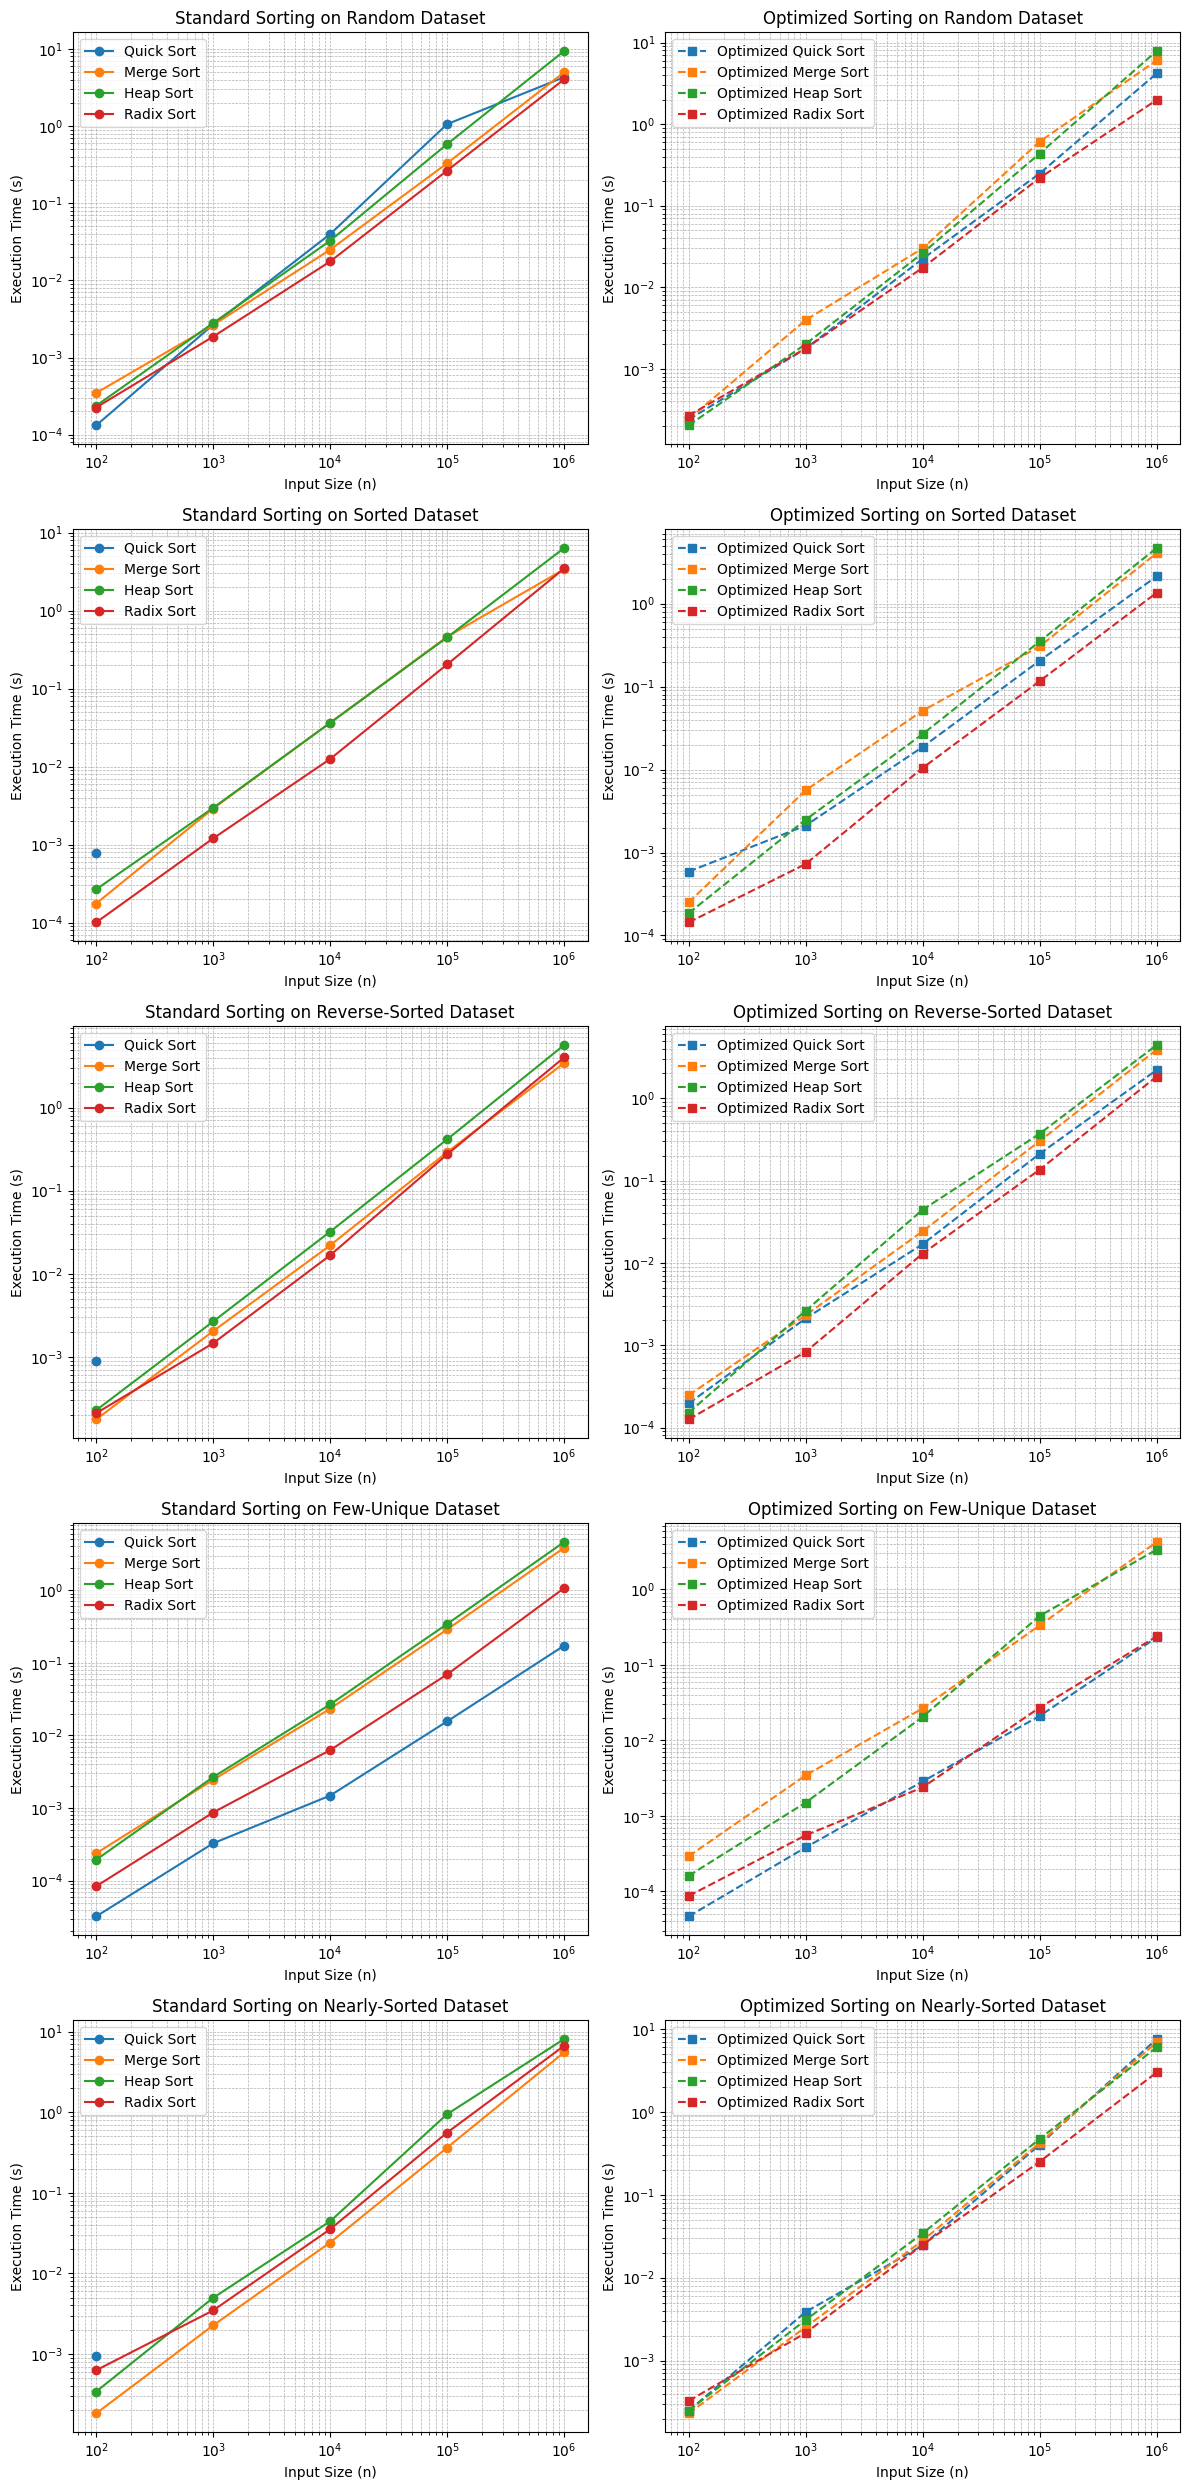

In [28]:
dataset_types = ["Random", "Sorted", "Reverse-Sorted", "Few-Unique", "Nearly-Sorted"]
sorting_algorithms = list(algorithms.keys())
plot_per_dataset_type(all_results_standard, all_results_optimized, dataset_types, sorting_algorithms)